In [1]:
import numpy as np
import torch

import yaml
import tiktoken

In [2]:
from main import initialize_weights, dataloader, forward, backward, cross_entropy, cross_entropy_backward

In [3]:
with open('config.yaml', 'r') as file:
        cfg = yaml.safe_load(file)
        assert cfg['model_dim'] % cfg['num_heads'] == 0, 'model_dim must be divisible by num_heads'

weights = initialize_weights(cfg)

In [4]:
enc = tiktoken.get_encoding("gpt2")
file = open('tokenizer/data/toy_data3.txt', 'r')
content = file.read()
tokens = enc.encode(content, allowed_special={"<|endoftext|>"})

In [5]:
inputs, targets = dataloader(tokens, cfg['batch_size'], cfg['seq_length'])

<class 'list'>


## PyTorch

In [6]:
import speedscope
import torch.nn.functional as F
import torch.nn as nn

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:

torch_weights = {}

for key, value in weights.items():
    torch_weights[key] = torch.tensor(value, requires_grad=True, device=device)


torch_weights = nn.ParameterDict({
            key: nn.Parameter(value) for key, value in torch_weights.items()
        })

In [9]:
def qkv_proj_torch(x, W_Q, W_K, W_V):
    return torch.matmul(x, W_Q), torch.matmul(x, W_K), torch.matmul(x, W_Q)

In [10]:
def mha_torch(q, k, v, causal_mask, dropout_p=0.1, training=True):
    scale = 1.0 / np.sqrt(q.shape[-1])

    attn_scores = q @ k.transpose(2, 3)
    # attn_scores_masked = torch.where(casual_mask, attn_scores, torch.tensor(float('-inf'), device=device))
    attn_scores = attn_scores.masked_fill(~causal_mask, float('-inf'))

    attn = torch.softmax(attn_scores * scale, dim=-1)

    attn = F.dropout(attn, p=dropout_p, training=training)

    return torch.matmul(attn, v)

In [11]:
def layer_norm_torch(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor) -> torch.Tensor:
    mu = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True)
    return gamma * (x - mu) / torch.sqrt(var + 1e-6) + beta

In [12]:
def feed_forward_network_torch(x: torch.Tensor, W_1: torch.Tensor, W_2: torch.Tensor):
    return F.relu(x @ W_1) @ W_2

In [13]:
def prepare_qkv_multihead(q ,k, v, cfg):
    B, S, DK, H = cfg['batch_size'], cfg['seq_length'], cfg['head_dim'], cfg['num_heads']
    return (
        q.view(B, S, DK, H).swapaxes(1,2),
        k.view(B, S, DK, H).swapaxes(1,2),
        v.view(B, S, DK, H).swapaxes(1,2)
    )

In [14]:
def block_forward_torch(x: np.ndarray,
                  W_Q: np.ndarray, W_K: np.ndarray, W_V: np.ndarray,
                  W_O: np.ndarray, W_FF_expand: np.ndarray, W_FF_contract: np.ndarray,
                  gamma1: np.ndarray, beta1: np.ndarray, gamma2: np.ndarray, beta2: np.ndarray, causal_mask, dropout_p=0.3, training=True):
    q, k, v = qkv_proj_torch(x, W_Q, W_K, W_V)
    q, k, v = prepare_qkv_multihead(q, k, v, cfg)
    attn_o = mha_torch(q, k, v, causal_mask, dropout_p=dropout_p, training=training).contiguous().view(cfg['batch_size'],cfg['seq_length'], cfg['model_dim']) @ W_O
    attn_o = F.dropout(attn_o, p=dropout_p, training=training)
    ln1 = layer_norm_torch(x + attn_o, gamma1, beta1)
    ff = feed_forward_network_torch(ln1, W_FF_expand, W_FF_contract)
    ff = F.dropout(ff, p=dropout_p, training=training)
    return layer_norm_torch(ln1 + ff, gamma2, beta2)

In [15]:
from typing import Dict

def forward_torch(x: np.ndarray, cfg: Dict, weights: Dict, causal_mask):
    for layer in range(cfg['n_layers']):
            x = block_forward_torch(x,
                W_Q= weights['W_Q'][layer],
                W_K= weights['W_K'][layer],
                W_V= weights['W_V'][layer],
                W_O= weights['W_O'][layer],
                W_FF_expand= weights['W_FFN_E'][layer],
                W_FF_contract= weights['W_FFN_C'][layer],
                gamma1= weights['GAMMA_1'][layer],
                beta1= weights['BETA_1'][layer],
                gamma2= weights['GAMMA_2'][layer],
                beta2= weights['BETA_2'][layer],
                causal_mask=causal_mask)
        
    return x @ weights['W_LOGITS']

In [16]:
cross_entropy = nn.CrossEntropyLoss()

In [17]:
optimizer = torch.optim.AdamW(torch_weights.parameters(), lr=1e-2)

In [18]:
inputs.shape

(1025, 2, 256)

In [19]:
# for epoch in range(0, 10):
epoch=0
with speedscope.track('test2.json'):
    causal_mask = torch.tril(torch.ones((cfg['seq_length'], cfg['seq_length']), dtype=torch.bool, device=device))
    
    for batch_idx, (batch_input, batch_target) in enumerate(list(zip(inputs, targets))):
        input_emb_torch = torch.tensor(weights['W_TE'][batch_input] + weights['W_PE'][np.arange(cfg['seq_length'])], device=device) # S x D
        logits_torch = forward_torch(input_emb_torch, cfg, torch_weights, causal_mask)
        # print(f"Memory logits: {logits_torch.nbytes / (1024 ** 2):.2f} MB")
        loss =  cross_entropy(logits_torch.flatten(0,1), torch.tensor(batch_target, device=device).flatten(0,1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch} - Batch: {batch_idx} - Loss: ", loss.item())

Epoch 0 - Batch: 0 - Loss:  14.210857998904428
Epoch 0 - Batch: 10 - Loss:  8.110048020520338
Epoch 0 - Batch: 20 - Loss:  6.857766112209157
Epoch 0 - Batch: 30 - Loss:  5.999039864715028
Epoch 0 - Batch: 40 - Loss:  6.493383804757441
Epoch 0 - Batch: 50 - Loss:  6.5259132714073225
Epoch 0 - Batch: 60 - Loss:  6.270557592589938
Epoch 0 - Batch: 70 - Loss:  6.266079456745635
Epoch 0 - Batch: 80 - Loss:  5.889122102793326
Epoch 0 - Batch: 90 - Loss:  6.392101912333348
Epoch 0 - Batch: 100 - Loss:  6.10473593536343
Epoch 0 - Batch: 110 - Loss:  6.223702062226585
Epoch 0 - Batch: 120 - Loss:  6.232325884742817
Epoch 0 - Batch: 130 - Loss:  6.237546957911736
Epoch 0 - Batch: 140 - Loss:  5.938281437975576


KeyboardInterrupt: 

In [40]:
torch_weights

ParameterDict(
    (BETA_1): Parameter containing: [torch.cuda.DoubleTensor of size 5x500 (cuda:0)]
    (BETA_2): Parameter containing: [torch.cuda.DoubleTensor of size 5x500 (cuda:0)]
    (GAMMA_1): Parameter containing: [torch.cuda.DoubleTensor of size 5x500 (cuda:0)]
    (GAMMA_2): Parameter containing: [torch.cuda.DoubleTensor of size 5x500 (cuda:0)]
    (W_FFN_C): Parameter containing: [torch.cuda.DoubleTensor of size 5x2000x500 (cuda:0)]
    (W_FFN_E): Parameter containing: [torch.cuda.DoubleTensor of size 5x500x2000 (cuda:0)]
    (W_K): Parameter containing: [torch.cuda.DoubleTensor of size 5x500x500 (cuda:0)]
    (W_LOGITS): Parameter containing: [torch.cuda.DoubleTensor of size 500x50257 (cuda:0)]
    (W_O): Parameter containing: [torch.cuda.DoubleTensor of size 5x500x500 (cuda:0)]
    (W_PE): Parameter containing: [torch.cuda.DoubleTensor of size 250x500 (cuda:0)]
    (W_Q): Parameter containing: [torch.cuda.DoubleTensor of size 5x500x500 (cuda:0)]
    (W_TE): Parameter conta

In [355]:
loss.backward()

In [360]:
torch_weights.parameters()

<generator object Module.parameters at 0x744d405cac00>

In [323]:
torch_weights['BETA_1']

tensor([[0.9367, 0.2438, 0.8679,  ..., 0.1830, 0.0647, 0.9720],
        [0.2205, 0.9721, 0.3874,  ..., 0.0605, 0.1455, 0.1703],
        [0.4249, 0.8732, 0.0691,  ..., 0.4618, 0.1006, 0.4054],
        [0.1938, 0.4645, 0.0212,  ..., 0.0952, 0.1445, 0.3747],
        [0.3094, 0.5549, 0.7745,  ..., 0.9942, 0.4628, 0.7367]],
       dtype=torch.float64, requires_grad=True)

In [324]:
torch_weights['BETA_1'].grad

tensor([[-2.3228e-16, -2.8518e-16, -4.3410e-17,  ...,  1.0248e-17,
          6.0089e-17,  4.8958e-17],
        [-8.1870e-14,  1.6900e-13, -1.6723e-13,  ...,  4.3893e-14,
         -4.3045e-14, -2.2347e-13],
        [-1.4010e-10, -2.8576e-10,  3.2164e-10,  ..., -2.0749e-11,
         -7.0222e-10,  2.9177e-10],
        [ 9.8166e-08,  5.5805e-07, -1.0377e-06,  ..., -8.0700e-08,
          2.0291e-07, -3.8876e-08],
        [-8.5177e-03, -1.5934e-03,  3.8098e-03,  ...,  3.9974e-03,
          1.3049e-02,  3.5298e-03]], dtype=torch.float64)

In [292]:
batch_target

array([[ 7454,  2402,   257, ...,  2474,   440,   297],
       [  494,  1509,   321, ...,  1545,    13,   198],
       [50256,   198,   198, ...,  1545,   373,   407],
       ...,
       [ 6938,   340,    13, ...,   198,     1, 10449],
       [  345,    11,  1995, ...,  1139,    11,   366],
       [ 5297,    11,   314, ...,  2993,   326,   262]], shape=(20, 250))

In [214]:
logits_torch.shape

torch.Size([50, 250, 50257])

In [110]:
torch.manual_seed(123)
x = torch.rand((2,3,4))
x

tensor([[[0.2961, 0.5166, 0.2517, 0.6886],
         [0.0740, 0.8665, 0.1366, 0.1025],
         [0.1841, 0.7264, 0.3153, 0.6871]],

        [[0.0756, 0.1966, 0.3164, 0.4017],
         [0.1186, 0.8274, 0.3821, 0.6605],
         [0.8536, 0.5932, 0.6367, 0.9826]]])

In [111]:
q = torch.rand((4,4))
q

tensor([[0.2745, 0.6584, 0.2775, 0.8573],
        [0.8993, 0.0390, 0.9268, 0.7388],
        [0.7179, 0.7058, 0.9156, 0.4340],
        [0.0772, 0.3565, 0.1479, 0.5331]])

In [112]:
k = torch.rand((4, 4))
k

tensor([[0.4066, 0.2318, 0.4545, 0.9737],
        [0.4606, 0.5159, 0.4220, 0.5786],
        [0.9455, 0.8057, 0.6775, 0.6087],
        [0.6179, 0.6932, 0.4354, 0.0353]])

In [133]:
v = torch.rand((4, 4))
v

tensor([[0.1908, 0.9268, 0.5299, 0.0950],
        [0.5789, 0.9131, 0.0275, 0.1634],
        [0.3009, 0.5201, 0.3834, 0.4451],
        [0.0126, 0.7341, 0.9389, 0.8056]])

In [113]:
q1 = q[:, :2]
q2 = q[:, 2:]

In [114]:
k1 = k[:, :2]
k2 = k[:, 2:]

In [134]:
v1 = v[:, :2]
v2 = v[:, 2:]

In [127]:
Q1 = x @ q1
Q1

tensor([[[0.7796, 0.6382],
         [0.9055, 0.2154],
         [0.9832, 0.6170]],

        [[0.4557, 0.4240],
         [1.1019, 0.6155],
         [1.3006, 1.3849]]])

In [130]:
Q2 = x @ q2
Q2

tensor([[[0.8932, 1.1117],
         [0.9639, 0.8175],
         [1.1146, 1.1975]],

        [[0.5524, 0.5616],
         [1.2473, 1.2308],
         [1.5150, 1.9701]]])

In [117]:
Q = x @ q
Q

tensor([[[0.7796, 0.6382, 0.8932, 1.1117],
         [0.9055, 0.2154, 0.9639, 0.8175],
         [0.9832, 0.6170, 1.1146, 1.1975]],

        [[0.4557, 0.4240, 0.5524, 0.5616],
         [1.1019, 0.6155, 1.2473, 1.2308],
         [1.3006, 1.3849, 1.5150, 1.9701]]])

In [118]:
B, S, D = Q.shape
Q.view(B, S, D // 2, 2).swapaxes(1,2)

tensor([[[[0.7796, 0.6382],
          [0.9055, 0.2154],
          [0.9832, 0.6170]],

         [[0.8932, 1.1117],
          [0.9639, 0.8175],
          [1.1146, 1.1975]]],


        [[[0.4557, 0.4240],
          [1.1019, 0.6155],
          [1.3006, 1.3849]],

         [[0.5524, 0.5616],
          [1.2473, 1.2308],
          [1.5150, 1.9701]]]])

In [119]:
K1 = x @ k1

In [120]:
K2 = x @ k2

In [121]:
K = x @ k
K

tensor([[[1.0217, 1.0152, 0.8229, 0.7647],
         [0.6216, 0.6452, 0.5365, 0.6601],
         [1.1321, 1.1477, 0.9030, 0.8157]],

        [[0.6687, 0.6524, 0.5066, 0.3942],
         [1.1987, 1.2200, 0.9495, 0.8501],
         [1.8295, 1.6980, 1.4975, 1.5966]]])

In [135]:
V1 = x @ v1

In [136]:
V2 = x @ v2

In [137]:
V = x @ v

In [179]:
Q

tensor([[[0.7796, 0.6382, 0.8932, 1.1117],
         [0.9055, 0.2154, 0.9639, 0.8175],
         [0.9832, 0.6170, 1.1146, 1.1975]],

        [[0.4557, 0.4240, 0.5524, 0.5616],
         [1.1019, 0.6155, 1.2473, 1.2308],
         [1.3006, 1.3849, 1.5150, 1.9701]]])

tensor([[[[0.7796, 0.6382],
          [0.9055, 0.2154],
          [0.9832, 0.6170]],

         [[0.8932, 1.1117],
          [0.9639, 0.8175],
          [1.1146, 1.1975]]],


        [[[0.4557, 0.4240],
          [1.1019, 0.6155],
          [1.3006, 1.3849]],

         [[0.5524, 0.5616],
          [1.2473, 1.2308],
          [1.5150, 1.9701]]]])

In [199]:
m = mha_torch(Q.view(B, S, D // 2, 2).swapaxes(1,2), K.view(B, S, D // 2, 2).swapaxes(1,2), V.view(B, S, D // 2, 2).swapaxes(1,2))
m

tensor([[[[0.4399, 1.3825],
          [0.4898, 1.2235],
          [0.5161, 1.3447]],

         [[0.9141, 0.7792],
          [0.6075, 0.5666],
          [0.7216, 0.6739]]],


        [[[0.2285, 0.7091],
          [0.4898, 1.2628],
          [0.6495, 2.0459]],

         [[0.5440, 0.5038],
          [0.7558, 0.7408],
          [1.4572, 1.1515]]]])

In [204]:
m.swapaxes(1,2).contiguous().view(2,3,4)

tensor([[[0.4399, 1.3825, 0.9141, 0.7792],
         [0.4898, 1.2235, 0.6075, 0.5666],
         [0.5161, 1.3447, 0.7216, 0.6739]],

        [[0.2285, 0.7091, 0.5440, 0.5038],
         [0.4898, 1.2628, 0.7558, 0.7408],
         [0.6495, 2.0459, 1.4572, 1.1515]]])

In [139]:
(Q1 @ K1.swapaxes(-2,-1)) @ V1

tensor([[[ 2.0387,  5.3253],
         [ 1.6063,  4.1993],
         [ 2.2989,  6.0061]],

        [[ 1.9008,  5.7660],
         [ 3.7283, 11.3178],
         [ 5.7946, 17.5743]]])

In [138]:
(Q2 @ K2.swapaxes(-2,-1)) @ V2

tensor([[[ 3.2193,  3.0115],
         [ 2.8780,  2.6895],
         [ 3.7214,  3.4798]],

        [[ 3.9452,  3.2625],
         [ 8.7762,  7.2580],
         [12.3464, 10.2033]]])

In [144]:
torch.concat(((Q1 @ K1.swapaxes(-2,-1)) @ V1, (Q2 @ K2.swapaxes(-2,-1)) @ V2), dim=-1)

tensor([[[ 2.0387,  5.3253,  3.2193,  3.0115],
         [ 1.6063,  4.1993,  2.8780,  2.6895],
         [ 2.2989,  6.0061,  3.7214,  3.4798]],

        [[ 1.9008,  5.7660,  3.9452,  3.2625],
         [ 3.7283, 11.3178,  8.7762,  7.2580],
         [ 5.7946, 17.5743, 12.3464, 10.2033]]])

In [176]:
B, S, D = Q.shape
((Q.view(B, S, D // 2, 2).swapaxes(1,2) @ K.view(B, S, D // 2, 2).swapaxes(1,2).swapaxes(-2, -1)) @ V.view(B, S, D // 2, 2).swapaxes(1,2)).swapaxes(1,2).flatten(start_dim=2, end_dim=3)

tensor([[[ 2.0387,  5.3253,  3.2193,  3.0115],
         [ 1.6063,  4.1993,  2.8780,  2.6895],
         [ 2.2989,  6.0061,  3.7214,  3.4798]],

        [[ 1.9008,  5.7660,  3.9452,  3.2625],
         [ 3.7283, 11.3178,  8.7762,  7.2580],
         [ 5.7946, 17.5743, 12.3464, 10.2033]]])

In [151]:
D

4

In [109]:
x.shape

torch.Size([2, 3, 4])

In [21]:
inputs[0]

array([[  198,  7454,  2402, ...,  8073,  2474,   440],
       [  297,   494,  1509, ...,   649,  1545,    13],
       [  198, 50256,   198, ...,   770,  1545,   373],
       ...,
       [ 2933,    11,   290, ...,   290,  4193,   683],
       [   13, 26089,  7121, ...,  3496,   329,  1610],
       [15352,    13,  1610, ...,  1995,    13,  1119]], shape=(50, 250))

In [1]:
import sys
import os
import numpy as np

from tokenizer.EncoderDecoder import encoder, decoder
from tokenizer.utils import load_bpe, render_token

from io import BufferedReader
import matplotlib.pyplot as plt
import functools
import multiprocessing
from tqdm import tqdm, trange
import math

import torch
import torch.nn.functional as F
import regex as re

In [7]:
import tiktoken

In [16]:
enc = tiktoken.get_encoding("gpt2")

In [17]:
file = open('tokenizer/data/TinyStoriesV2-GPT4-train.txt')

In [18]:
with open('tokenizer/data/toy_data3.txt', 'a') as f:
    for idx, line in enumerate(file.readlines()):
        if idx < 15000:
            f.write(line)

In [ ]:
enc.encode_batch()

In [5]:
enc.decode([27737,14343,50256,38582,41130,41130,50256,45236,41534,50256])

' sunny scary<|endoftext|>Suddenly hugged hugged<|endoftext|> gasped softened<|endoftext|>'

In [6]:
enc.max_token_value

50256

In [158]:
enc.encode("Hello world!")

[15496, 995, 0]

In [ ]:
def softmax(x: np.ndarray) -> np.ndarray:
    x = x - x.max(axis=-1, keepdims=True)
    ex = np.exp(x)
    return ex / ex.sum(axis=-1, keepdims=True)

In [ ]:
def cross_entropy(logits, targets):
    probas = softmax(logits)
    probas_flatten = probas.reshape(probas.shape[0] * probas.shape[1], probas.shape[2])
    targets_flatten = targets.reshape(targets.shape[0] * targets.shape[1])
    target_probas = probas_flatten[np.arange(probas_flatten.shape[0]), targets_flatten]
    log_probas = np.log(target_probas)
    neg_avg_log_probas = -np.mean(log_probas, axis=-1)

    return neg_avg_log_probas

In [129]:
logits = np.array([[[1,2,3,4],
                   [5,6,7,8],
                   [9,10,11,12]],
                   [[11,12,13,14],
                   [15,16,17,18],
                   [19,110,111,112]]])
logits.shape

(2, 3, 4)

In [130]:
targets = np.array([[0,3,3],
                    [1,1,1]])
targets.shape

(2, 3)

In [131]:
logits[[[0],[1]], [0,1,2], targets]

array([[  1,   8,  12],
       [ 12,  16, 110]])

In [132]:
logits_flat = logits.reshape(6,4)
targets_flat = targets.reshape(6)

In [133]:
targets_flat

array([0, 3, 3, 1, 1, 1])

In [134]:
logits_flat[np.arange(6), targets_flat]

array([  1,   8,  12,  12,  16, 110])

In [135]:
cross_entropy(logits, targets)

np.float64(1.9347590762083928)

In [136]:
logits_torch = torch.tensor(logits).flatten(0,1)
targets_torch = torch.tensor(targets).flatten()

In [ ]:
torch.nn.functional.cross_entropy(, )

NotImplementedError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

In [13]:
logits.reshape(6, 4)

array([[  1,   2,   3,   4],
       [  5,   6,   7,   8],
       [  9,  10,  11,  12],
       [ 11,  12,  13,  14],
       [ 15,  16,  17,  18],
       [ 19, 110, 111, 112]])

In [50]:
logits[0, [0,1,2], targets[0]]

array([ 1,  8, 12])

In [34]:
logits[np.arange(logits.shape[0])[:, None], np.arange(logits.shape[1]), targets]

array([[  1,   8,  12],
       [ 12,  16, 110]])

In [17]:
NPROC = 16
VOCAB_SIZE = 2560
D = 504 # model dimension (embeddings)
S = 100 # Sequence lenght (context)

# Tokenization

In [ ]:
def get_chunk_boundaries(file_path: str, special_token: str = '<|endoftext|>'):
    f: BufferedReader = open(file_path, 'rb')
    content = f.read()
    f.close()    

    chunk_starts = [0]
    start_index = 0
    while True:
        match_index = content.find(special_token.encode('utf-8'), start_index)
        if match_index == -1:
            break
        chunk_starts.append(match_index + len(special_token))
        start_index = match_index + len(special_token)
    chunk_ends = chunk_starts[1:]
    chunk_ends.append(len(content))
    chunk_boundaries = list(zip(chunk_starts, chunk_ends))

    return chunk_boundaries

In [ ]:
def encode_chunk(chunk_boundaries: tuple, file_path: str, model: str):
    f = open(file_path, 'rb')
    chunk_start, chunk_end = chunk_boundaries
    
    f.seek(chunk_start)

    tokens = encoder(f.read(chunk_end-chunk_start).decode(), model=model)
    f.close()
    return tokens, len(tokens)

In [ ]:
def tokenize_train_data(file_path: str, tokenizer:str):
    encode_f = functools.partial(encode_chunk, file_path=file_path, model=tokenizer)

    chunks_boundaries = get_chunk_boundaries(file_path=file_path)

    chunks_tokens = []
    with multiprocessing.Pool(NPROC) as p:
        for chunk in tqdm(p.imap_unordered(encode_f, chunks_boundaries), total=len(chunks_boundaries), desc="Tokenizing"):
            chunks_tokens.extend(chunk)
        p.close()
        p.join()
    
    return chunks_tokens

In [ ]:
get_chunk_boundaries('tokenizer/data/toy_data.txt')

[(0, 823),
 (823, 2792),
 (2792, 3832),
 (3832, 4499),
 (4499, 6341),
 (6341, 7317),
 (7317, 9255),
 (9255, 9837),
 (9837, 10652),
 (10652, 11496),
 (11496, 12167),
 (12167, 13097),
 (13097, 13811),
 (13811, 14337),
 (14337, 15516),
 (15516, 16218),
 (16218, 16856),
 (16856, 17494),
 (17494, 18263),
 (18263, 19565),
 (19565, 21807),
 (21807, 22670),
 (22670, 23303),
 (23303, 24013),
 (24013, 24601),
 (24601, 25415),
 (25415, 26169),
 (26169, 26750),
 (26750, 27551),
 (27551, 28070),
 (28070, 29399),
 (29399, 30215),
 (30215, 30932),
 (30932, 31760),
 (31760, 32354),
 (32354, 32987),
 (32987, 33782),
 (33782, 34540),
 (34540, 35268),
 (35268, 36692),
 (36692, 37404),
 (37404, 38128),
 (38128, 38990),
 (38990, 39654),
 (39654, 40812),
 (40812, 41790),
 (41790, 42453),
 (42453, 43329),
 (43329, 44028),
 (44028, 45110),
 (45110, 45667),
 (45667, 46580),
 (46580, 47223),
 (47223, 47814),
 (47814, 48738),
 (48738, 49585),
 (49585, 50367),
 (50367, 50971),
 (50971, 51711),
 (51711, 52264),
 (

In [ ]:
f = open('tokenizer/data/toy_data.txt', 'rb')

In [ ]:
f.seek(0)
text = f.read(823)

In [ ]:
len(encoder(text.decode(), model='tinystories-2560', special_tokens=['<|endoftext|>']))

221

In [ ]:
tokens = tokenize_train_data('tokenizer/data/toy_data.txt', tokenizer='tinystories')

Tokenizing: 100%|██████████| 460/460 [00:04<00:00, 111.31it/s]


In [ ]:
tokens

[([10,
   382,
   1019,
   986,
   44,
   258,
   458,
   401,
   414,
   1033,
   343,
   366,
   46,
   315,
   533,
   375,
   710,
   262,
   633,
   282,
   387,
   269,
   298,
   46,
   414,
   406,
   265,
   506,
   116,
   341,
   326,
   44,
   390,
   285,
   451,
   258,
   345,
   342,
   618,
   392,
   46,
   315,
   342,
   618,
   813,
   341,
   484,
   103,
   115,
   44,
   341,
   511,
   44,
   266,
   341,
   256,
   921,
   46,
   423,
   533,
   344,
   634,
   121,
   266,
   557,
   46,
   10,
   733,
   426,
   697,
   265,
   324,
   46,
   315,
   381,
   341,
   357,
   44,
   258,
   464,
   401,
   513,
   46,
   513,
   282,
   1060,
   342,
   618,
   392,
   298,
   312,
   262,
   1019,
   986,
   633,
   46,
   311,
   718,
   533,
   377,
   375,
   46,
   311,
   708,
   265,
   324,
   456,
   266,
   498,
   442,
   431,
   326,
   46,
   10,
   1217,
   262,
   869,
   369,
   262,
   326,
   44,
   414,
   266,
   513,
   404,
   1134,
   46

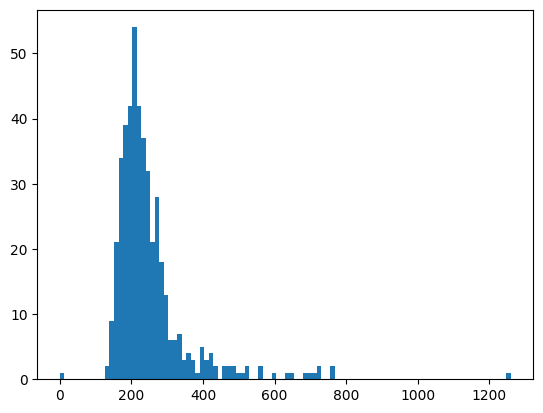

In [ ]:
lenghts = [ lenght for _, lenght in tokens ]
plt.hist(lenghts, bins=100);

In [ ]:
bytes([255]).decode()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [ ]:
def dataloader(chunks: list, B: int, S: int, stride: int):
    inputs = []
    targets = []
    for tokens, lenght in chunks:
        for idx in range(0, lenght - S - 1, stride):
            inputs.append(tokens[idx:idx + S])
            targets.append(tokens[idx+1:idx + S + 1])

    for i in range(0, len(inputs), B):
        batch_inputs = inputs[i:i + B]
        batch_targets = targets[i:i + B]
        
        if len(batch_inputs) == B:
            yield batch_inputs, batch_targets

    return batch_inputs, batch_targets

In [ ]:
def encoder(text: str, model: str, special_tokens: list = []):
    merges, vocab = load_bpe(model_name=model)

    pattern = '(' + '|'.join(re.escape(token) for token in special_tokens) + ')'
    chunks = re.split(pattern, text)

    tokens = []
    for chunk in chunks:
        if chunk in special_tokens:
            tokens.extend([vocab[tuple(chunk.encode('utf-8'))]])
        else:
            tokens.extend(list(chunk.encode('utf-8')))

    for merge in merges:
        updated_tokens = []
        i = 0
        while i < len(tokens):
            if i == len(tokens) - 1:
                updated_tokens.append(tokens[i])
                i += 1
            elif merge == (tokens[i], tokens[i + 1]):
                updated_tokens.append(merges[merge])
                i += 2
            else:
                updated_tokens.append(tokens[i])
                i += 1         
        tokens = updated_tokens
    return tokens

In [ ]:
encoder("Hello <|endoftext|> World!", model='tinystories-2560', special_tokens=["<|endoftext|>"])

[1183, 32, 256, 536, 304, 340, 33]

In [ ]:
decoder([1183, 32, 256, 536, 304, 340, 33], model='tinystories-2560')

'Hello <|endoftext|> World!'

In [ ]:
%debug

> /tmp/ipykernel_648637/4170651209.py(10)encoder()
      8     for chunk in chunks:
      9         if chunk in special_tokens:
---> 10             tokens.extend(vocab[tuple(chunk.encode('utf-8'))])
     11         else:
     12             tokens.extend(list(text.encode('utf-8')))

['Hello ', '<|endoftext|>', ' World!']
False
['<|endoftext|>']
'|'
'<|endoftext|>'
True
256


In [ ]:
decoder([60, 124, 353, 111, 791, 838, 116, 124, 62], model='tinystories-2560')

'<|endoftext|>'

In [ ]:
text = "Hello <|endoftext|> world!"
text = list(text.encode('utf-8'))

In [138]:

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [139]:
import torch
from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [140]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [141]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [142]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [143]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [144]:

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [145]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [146]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [147]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [148]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [149]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [150]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [151]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [154]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [152]:
logits_flat

tensor([[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
        [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
        [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217],
        [-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
        [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
        [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]])

In [153]:
cross_entropy(logits.numpy(), targets.numpy())

np.float32(10.793964)

In [42]:
targets_flat

tensor([ 3626,  6100,   345,  1107,   588, 11311])

In [24]:
import regex as re

In [ ]:
tuple(special_tokens[0].encode())

(60, 124, 101, 110, 100, 111, 102, 116, 101, 120, 116, 124, 62)

In [ ]:
special_tokens = ["<|endoftext|>"]
text = "Hello <|endoftext|> world!"
pattern = '(' + '|'.join(re.escape(token) for token in special_tokens) + ')'
chunks = re.split(pattern, text)

tokens = []
for chunk in chunks:
    if chunk in special_tokens:
        tokens.extend()


['Hello ', '<|endoftext|>', ' world!']

In [ ]:
_, vocab = load_bpe(model_name='tinystories-2560')

text = [ render_token(token, vocab) for token in tokens ]
if decode:
    return b''.join(text).decode()
else:
    return b''.join(text)

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
vocab[(60, 124, 101, 110, 100, 111, 102, 116, 101, 120, 116, 124, 62)]

256

# Embeddings 

In [ ]:
np.random.seed(123)

In [ ]:
S = 3           # Sequence lenght
D = 8           # Model dimension (embedding size)
N_HEADS = 2
D_K = D // N_HEADS         # Dimension of keys (used to scale attention)
B = 2
NBATCHES = 1
VOCAB_SIZE = 10

W_TE = np.random.rand(VOCAB_SIZE, D) # VOCAB_SIZE x D
W_PE = np.random.rand(S, D)

W_Q = np.random.rand(D, D_K * N_HEADS)
W_K = np.random.rand(D, D_K * N_HEADS)
W_V = np.random.rand(D, D_K * N_HEADS)
W_O = np.random.rand(D, D)

GAMMA = np.random.rand(B, S, 1)
BETA = np.random.rand(B, S, 1)

FFN_EXPCON_FAC = 4
W_FFN_E = np.random.rand(D, FFN_EXPCON_FAC * D)
W_FFN_C = np.random.rand(FFN_EXPCON_FAC * D, D)

W_LOGITS = np.random.rand(B, D, VOCAB_SIZE)

# GAMMA = np.ones((B,S,1))
# BETA = np.zeros((B,S,1))

# W_O = 
# W_FF_expand = 
# W_FF_contract =
# gamma =
# beta =

In [ ]:
from transformer import (
    softmax,
    relu,
    qkv_projection,
    layer_norm,
    feed_forward_network,
    block_forward,
    multi_head_attention_backward,
    softmax_backward_from_probs   
)

from transformer import multi_head_attention as mha_np
from transformer import multi_head_attention_backward as mha_back_np

from torch_primitives import torch_multi_head_attention_backward as mha_back_torch

In [ ]:
def multi_head_attention_mh(q: np.ndarray, k: np.ndarray, v: np.ndarray) -> np.ndarray:
    assert q.shape == k.shape

    # NOTE: swapaxes(1,2) is a final step after reshape to split the q matrix into each head
    #       the final swapaxes(2,3) in tensor k is for transpose in the attention score calculation
    attn_scores = q.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) @ k.reshape(B,S,N_HEADS,D_K).swapaxes(1,2).swapaxes(2,3)
    mask = np.tril(np.ones(attn_scores.shape), k=0).astype(bool)
    attn_scores_masked = np.where(mask, attn_scores, -np.inf)

    scale = 1.0 / np.sqrt(q.shape[-1])
    causal_attn = softmax(attn_scores_masked * scale)

    context_vectors = causal_attn @ v.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) # Applies same reshape and swap as q & k

    return context_vectors.swapaxes(1,2).reshape(B,S,D_K * N_HEADS) # Concat context vector from each head

In [ ]:
def block_forward(x: np.ndarray):
    q, k, v = qkv_projection(x, W_Q, W_K, W_V)
    print(f"qkv_proj: {(x.shape, q.shape, k.shape, v.shape)}")

    context_vec = multi_head_attention(q, k, v)
    attn_out = context_vec @ W_O
    print(f"causal attn: {attn_out.shape}")

    ln_attn = layer_norm(x + attn_out, GAMMA, BETA)
    print(f"layer norm (attn): {ln_attn.shape}")

    ffn = feed_forward_network(ln_attn, W_FFN_E, W_FFN_C)
    print(f"ffn: {ffn.shape}")

    ln_head = layer_norm(ln_attn + ffn, GAMMA, BETA)
    print(f"layer norm head: {ln_head.shape}")

    return ln_head


In [ ]:
data = np.random.randint(1, VOCAB_SIZE, (NBATCHES,B,S))

input_emb = W_TE[data] + W_PE[np.arange(S)] # S x D
print(f"data: {data.shape}")
print(f"input emb: {input_emb.shape}")

for batch in input_emb:
    l1 = block_forward(batch)
    l2 = block_forward(l1)
    l3 = block_forward(l2)
    logits = softmax(l3 @ W_LOGITS)
    tokens = np.argmax(logits[:-1], axis=-1)
tokens

data: (1, 2, 3)
input emb: (1, 2, 3, 8)
qkv_proj: ((2, 3, 8), (2, 3, 8), (2, 3, 8), (2, 3, 8))
causal attn: (2, 3, 8)
layer norm (attn): (2, 3, 8)
ffn: (2, 3, 8)
layer norm head: (2, 3, 8)
qkv_proj: ((2, 3, 8), (2, 3, 8), (2, 3, 8), (2, 3, 8))
causal attn: (2, 3, 8)
layer norm (attn): (2, 3, 8)
ffn: (2, 3, 8)
layer norm head: (2, 3, 8)
qkv_proj: ((2, 3, 8), (2, 3, 8), (2, 3, 8), (2, 3, 8))
causal attn: (2, 3, 8)
layer norm (attn): (2, 3, 8)
ffn: (2, 3, 8)
layer norm head: (2, 3, 8)


array([[3, 3, 0]])

In [ ]:
np.random.seed(123)
q = np.random.rand(2,1,3,4)
k = np.random.rand(2,1,3,4)
v = np.random.rand(2,1,3,4)

dOut = np.random.rand(2,1,3,4)

In [ ]:
mha_np(q, k, v, unmasked=False)#.sum(axis=-1, keepdims=True)

array([[[[0.51948512, 0.61289453, 0.12062867, 0.8263408 ],
         [0.55812428, 0.58153635, 0.22332821, 0.5849033 ],
         [0.51260863, 0.61351953, 0.4474817 , 0.54803669]]],


       [[[0.66931378, 0.58593655, 0.6249035 , 0.67468905],
         [0.74549826, 0.36457956, 0.68600801, 0.48490987],
         [0.54490799, 0.45948477, 0.47326716, 0.64405419]]]])

In [ ]:
mha_np(q, k, v)#.sum(axis=-1, keepdims=True)

ValueError: cannot reshape array of size 24 into shape (1,4,2,8)

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
def mha_torch(q, k, v):
    q_torch = torch.from_numpy(q).float().requires_grad_(True)
    k_torch = torch.from_numpy(k).float().requires_grad_(True)
    v_torch = torch.from_numpy(v).float().requires_grad_(True)

    # Multi-head attention forward pass
    d_h = q_torch.shape[-1]
    mask = torch.triu(torch.ones(2,3,3), diagonal=1)
    attn_scores = q_torch @ k_torch.transpose(-2, -1) / np.sqrt(d_h)
    causal_attn_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
    attn_weights = F.softmax(causal_attn_scores, dim=-1)
    output_torch = attn_weights @ v_torch

    return output_torch

# output_torch.backward(dOut_torch)

In [ ]:
mha_torch(q, k, v)

tensor([[[[0.5195, 0.6129, 0.1206, 0.8263],
          [0.5581, 0.5815, 0.2233, 0.5849],
          [0.5126, 0.6135, 0.4475, 0.5480]],

         [[0.5195, 0.6129, 0.1206, 0.8263],
          [0.5581, 0.5815, 0.2233, 0.5849],
          [0.5126, 0.6135, 0.4475, 0.5480]]],


        [[[0.6693, 0.5859, 0.6249, 0.6747],
          [0.7455, 0.3646, 0.6860, 0.4849],
          [0.5449, 0.4595, 0.4733, 0.6441]],

         [[0.6693, 0.5859, 0.6249, 0.6747],
          [0.7455, 0.3646, 0.6860, 0.4849],
          [0.5449, 0.4595, 0.4733, 0.6441]]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
def multi_head_attention_backward(q: np.ndarray, k: np.ndarray, v: np.ndarray, dOut: np.ndarray):
    B, N_HEADS, S, D_K = q.shape
    scale = 1.0 / np.sqrt(D_K)

    attn_scores = q.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) @ k.reshape(B,S,N_HEADS,D_K).swapaxes(1,2).swapaxes(2,3)
    mask = np.tril(np.ones((B,N_HEADS,S,S)), k=0).astype(bool)
    attn_scores_masked = np.where(mask, attn_scores, -np.inf)

    scale = 1.0 / np.sqrt(q.shape[-1])
    causal_attn = softmax(attn_scores_masked * scale)

    dV = np.swapaxes(causal_attn, -2, -1) @ dOut.reshape(B,S,N_HEADS,D_K).swapaxes(1,2)
    dAttn = dOut.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) @ np.swapaxes(v.reshape(B,S,N_HEADS,D_K).swapaxes(1,2), -2, -1)

    dScores = softmax_backward_from_probs(causal_attn, dAttn)

    dQ = dScores @ k.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) * scale
    dK = np.swapaxes(dScores, -2, -1) @ q.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) * scale
    return dQ, dK, dV

In [ ]:
def torch_multi_head_attention_backward(q_np, k_np, v_np, dOut_np):
    """PyTorch implementation of multi-head attention backward pass"""
    q_torch = torch.from_numpy(q_np).float().requires_grad_(True)
    k_torch = torch.from_numpy(k_np).float().requires_grad_(True)
    v_torch = torch.from_numpy(v_np).float().requires_grad_(True)
    dOut_torch = torch.from_numpy(dOut_np).float()

    B, N_HEADS, S, D_K = q_torch.shape
    print(q_torch.shape)

    # Multi-head attention forward pass
    mask = torch.triu(torch.ones(B, N_HEADS, S, S), diagonal=1)
    attn_scores = q_torch @ k_torch.transpose(-2, -1) / np.sqrt(D_K)
    causal_attn_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
    attn_weights = F.softmax(causal_attn_scores, dim=-1)
    output_torch = attn_weights @ v_torch
    print(output_torch.shape)

    output_torch.backward(dOut_torch)

    return (
        q_torch.grad.detach().numpy(),
        k_torch.grad.detach().numpy(),
        v_torch.grad.detach().numpy(),
    )

In [ ]:
multi_head_attention_backward(q, k, v, dOut)[0]

array([[[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.01563788, -0.01123491,  0.0098367 , -0.00749334],
         [ 0.00040571, -0.00184811,  0.01019378, -0.00243235]]],


       [[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [-0.01165394,  0.04587054,  0.03697114,  0.00513161],
         [-0.0142082 ,  0.03768114,  0.02941429, -0.00509489]]]])

In [ ]:
torch_multi_head_attention_backward(q, k, v, dOut)[0]

torch.Size([2, 1, 3, 4])
torch.Size([2, 1, 3, 4])


array([[[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.01563788, -0.01123491,  0.0098367 , -0.00749334],
         [ 0.0004057 , -0.00184811,  0.01019377, -0.00243235]]],


       [[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [-0.01165394,  0.04587054,  0.03697114,  0.00513161],
         [-0.0142082 ,  0.03768113,  0.02941428, -0.0050949 ]]]],
      dtype=float32)

In [ ]:
mha_back_np(q, k, v, dOut)[0]

ValueError: cannot reshape array of size 24 into shape (1,3,1,4)

In [ ]:
mha_back_torch(q,k,v,dOut)[0]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.01563788, -0.01123491,  0.0098367 , -0.00749334],
        [ 0.0004057 , -0.00184811,  0.01019377, -0.00243235]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.01165394,  0.04587054,  0.03697114,  0.00513161],
        [-0.0142082 ,  0.03768113,  0.02941428, -0.0050949 ]]],
      dtype=float32)

In [ ]:
mask.bool().shape

torch.Size([2, 3, 3])

In [ ]:
attn_scores.shape

torch.Size([2, 3, 3])

In [ ]:
k.swapaxes(1,2).shape

(2, 4, 3)

In [ ]:
mha_back_torch(q, k, v, dOut)[0]

array([[[ 0.01127838, -0.00791101,  0.00586967, -0.00512856],
        [ 0.01035594, -0.00737556,  0.00610205, -0.00486952],
        [ 0.0004057 , -0.00184811,  0.01019377, -0.00243235]],

       [[-0.02505569,  0.03117587,  0.02159204, -0.03093255],
        [-0.01166164,  0.03306082,  0.0259736 , -0.00285432],
        [-0.0142082 ,  0.03768113,  0.02941428, -0.0050949 ]]],
      dtype=float32)

In [ ]:
a = np.array([[1,7,3],[4,5,6]])
a

array([[1, 7, 3],
       [4, 5, 6]])

In [ ]:
np.argmax(a, axis=0)

array([1, 0, 1])

In [ ]:
a = np.array([[[1,2],[3,4]],[[5,6],[7,8]]])

In [ ]:
a @ a

array([[[  7,  10],
        [ 15,  22]],

       [[ 67,  78],
        [ 91, 106]]])

In [ ]:
a[1] @ a[1]

array([[ 67,  78],
       [ 91, 106]])

In [ ]:
np.log(7.4541e-05)

np.float64(-9.504161248387373)